# Explanation
Samples are generated as a "poisson random walk" where the CN in first state is random poisson, and then the following CN=CN+jump where jump is a poisson random variable. Two clusters were simulated using different jump, initialization parameters and then they were clustered.

/Users/massoudmaher/Documents/Code/scgenome/venv/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/massoudmaher/Documents/Code/scgenome/venv/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [10.0, 10.0, 30.0, 30.0],
  [45.0, 45.0, 55.0, 55.0],
  [65.0, 65.0, 75.0, 75.0],
  [50.0, 50.0, 70.0, 70.0],
  [20.0, 20.0, 60.0, 60.0],
  [85.0, 85.0, 95.0, 95.0],
  [105.0, 105.0, 115.0, 115.0],
  [90.0, 90.0, 110.0, 110.0],
  [40.0, 40.0, 100.0, 100.0]],
 'dcoord': [[0.0, 78360.17959558574, 78360.17959558574, 0.0],
  [0.0, 45735.89612314391, 45735.89612314391, 0.0],
  [78360.17959558574,
   205305.98570420203,
   205305.98570420203,
   45735.89612314391],
  [0.0, 63401.027139651735, 63401.027139651735, 0.0],
  [0.0, 44450.76029747511, 44450.76029747511, 0.0],
  [63401.027139651735,
   161300.07221323962,
   161300.07221323962,
   44450.76029747511],
  [205305.98570420203,
   542980.0563453556,
   542980.0563453556,
   161300.07221323962],
  [0.0, 88047.48339224258, 88047.48339224258, 0.0],
  [0.0, 91109.48301403999, 91109.48301403999, 0.0],
  [88047.48339224258, 273227.7546311023, 273227.7546311023, 91109.48301403999

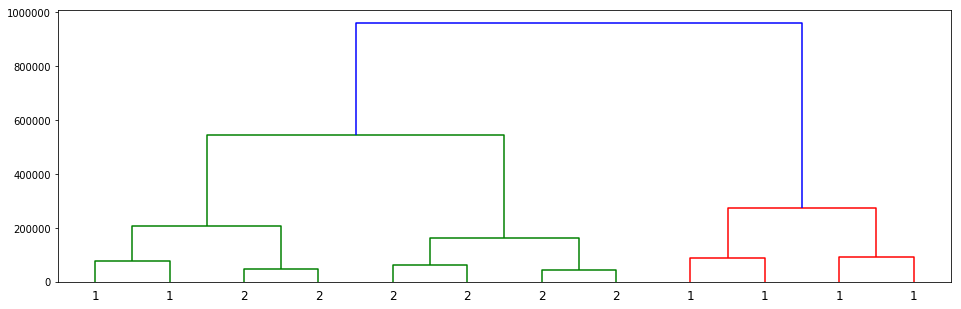

In [27]:
import scgenome.simulation as sim
import numpy as np
import pandas as pd
from IPython.display import display
from scgenome import cncluster
from scgenome.utils import cn_mat_to_cn_data, cn_mat_as_df
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

NUM_SAMPLE = 6
NUM_BIN = 1000
CHR_NAMES = ["1","2"]
max_cn=7

cluster1 = sim.cn_mat_poisson(NUM_SAMPLE, NUM_BIN, init_lambda=1., jump_lambda=1, seed=None, max_cn=max_cn)
cluster2 = sim.cn_mat_poisson(NUM_SAMPLE, NUM_BIN, init_lambda=3., jump_lambda=0.1, seed=None, max_cn=max_cn)

clst1_cell_ids = [f"cl1_cell{i}" for i in range(cluster1.shape[0])]
clst2_cell_ids = [f"cl2_cell{i}" for i in range(cluster1.shape[0])]

cn_mat = np.concatenate([cluster1, cluster2])
cell_ids = clst1_cell_ids + clst2_cell_ids

df_cn_mat = cn_mat_as_df(cn_mat,CHR_NAMES)
cn_data = cn_mat_to_cn_data(df_cn_mat, cell_id_vals=cell_ids)
cn_data["cluster_id"] = cn_data["cell_id"].str.split("_",expand=True).iloc[:,0]
cn_data["copy2"] = cn_data["copy"] + np.absolute(np.random.normal(size=cn_data.shape[0], scale=0.3))
cn_data.columns = ["chr", "bin", "cell_id", "state", "start", "end", "cluster_id", "copy"]

tlinkage, root, cell_ids = cncluster.bayesian_cluster(cn_data, n_states=max_cn, value_ids=["copy"])

plinkage = tlinkage[["i","j","r_merge","merge_count"]]
plinkage["r_merge"] = plinkage["r_merge"].astype("float")
plinkage["dist"] = -1 * plinkage["r_merge"]
plot_data = plinkage[["i","j","dist","merge_count"]].to_numpy().astype("float")

cell_ids = cell_ids.str[2]
fig = plt.figure(figsize=(16, 5))
dendrogram(plot_data, labels=cell_ids)

# Analysis
Doesn't work too well. The y-axis is `-marginal_log_likelihood` and the values are quite high so I question it. Should be getting good clustering

In [37]:
print(root.left_child)
print("\n")
print(root)

sample_inds : [0, 4, 7, 9, 6, 8, 10, 11], left_child : <scgenome.TNode.TNode object at 0x10b15e490> right_child : <scgenome.TNode.TNode object at 0x10b15e490> pi : None, d : None, ll : None, log_r : -542980.0563453556, cluster_ind : 21


sample_inds : [0, 4, 7, 9, 6, 8, 10, 11, 1, 3, 2, 5], left_child : <scgenome.TNode.TNode object at 0x10b15e190> right_child : <scgenome.TNode.TNode object at 0x10b15e190> pi : None, d : None, ll : None, log_r : -960384.3579722864, cluster_ind : 22
